<a href="https://colab.research.google.com/github/mrigankapaul-dhubri/BDSN_Mriganka/blob/main/Predicting_Employee_Attrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up the environment and importing the libraries

In [1]:
!apt-get update > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q pyspark


     |████████████████████████████████| 281.4 MB 26 kB/s 
     |████████████████████████████████| 198 kB 30.3 MB/s 


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [3]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T


from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler
from pyspark.ml.classification import GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [5]:
spark

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.mllib.stat import Statistics

# Uploading the file

Loading the csv file in the google colabenv using the below code

In [9]:
from google.colab import files
uploaded = files.upload()

Saving HR_comma_sep.csv to HR_comma_sep.csv


Reading the csv file below

In [10]:
df = spark.read.csv("HR_comma_sep.csv",inferSchema = True, header = True)

# Exploratory Data Analysis

Reading the features and its data types.

In [11]:
df.printSchema()

root
 |-- satisfaction_level: double (nullable = true)
 |-- last_evaluation: double (nullable = true)
 |-- number_project: integer (nullable = true)
 |-- average_montly_hours: integer (nullable = true)
 |-- time_spend_company: integer (nullable = true)
 |-- Work_accident: integer (nullable = true)
 |-- left: integer (nullable = true)
 |-- promotion_last_5years: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- salary: string (nullable = true)



Reading the first 2 records of the data

In [12]:
df.show(2)

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+
|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|department|salary|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+
|              0.38|           0.53|             2|                 157|                 3|            0|   1|                    0|     sales|   low|
|               0.8|           0.86|             5|                 262|                 6|            0|   1|                    0|     sales|medium|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+
only showing top 2 rows



Checking the count of records and features

In [13]:
print((df.count(), len(df.columns)))

(14999, 10)


Checking the count, mean, standard deviation, min and max of double or integer features and for the features with string datatype we can see the count, min and max 

In [14]:
df.describe().toPandas()

,summary,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,count,14999,14999,14999,14999,14999,14999,14999,14999,14999,14999
1,mean,0.6128335222348166,0.7161017401159978,3.80305353690246,201.0503366891126,3.498233215547703,0.1446096406427095,0.2380825388359224,0.021268084538969265,None,None
2,stddev,0.24863065106114257,0.17116911062327556,1.2325923553183513,49.94309937128406,1.4601362305354808,0.35171855238017957,0.42592409938029885,0.1442814645785825,None,None
3,min,0.09,0.36,2,96,2,0,0,0,IT,high
4,max,1.0,1.0,7,310,10,1,1,1,technical,medium


Checking the distribution of the numeric features whose datatypes are "double" or "integer"

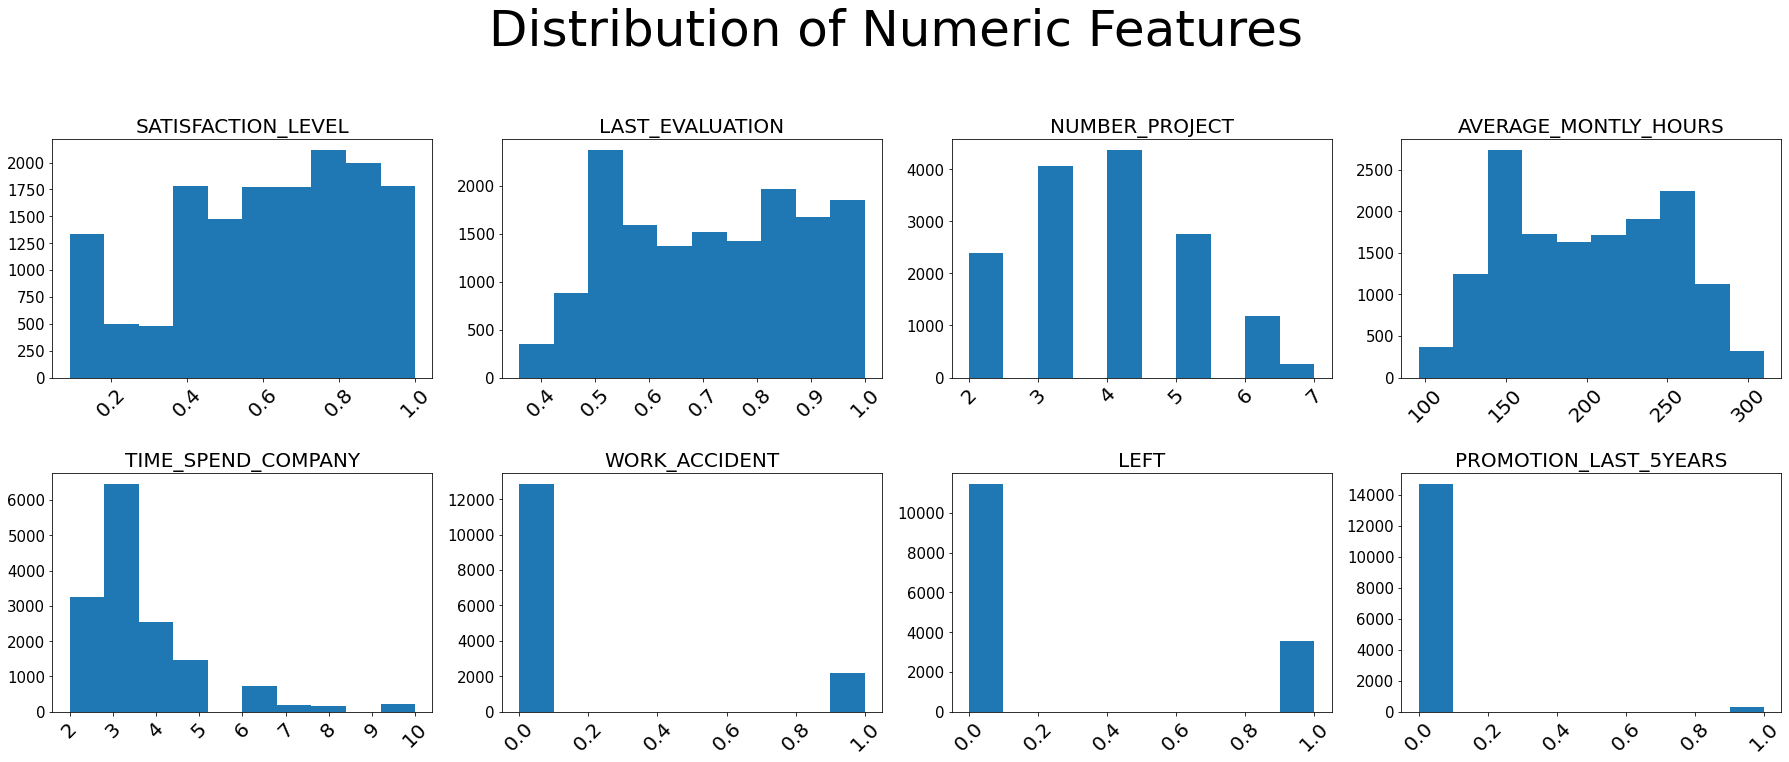

In [15]:
fig = plt.figure(figsize=(25, 15))
st = fig.suptitle("Distribution of Numeric Features", fontsize=50, verticalalignment="center")
for col, num in zip(df.toPandas().describe().columns, range(1,11)):
  ax = fig.add_subplot(3,4, num)
  ax.hist(df.toPandas()[col])
  plt.grid(False)
  plt.xticks(rotation=45, fontsize=20)
  plt.yticks(fontsize=15)
  plt.title(col.upper(), fontsize=20)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

Checking the number of employees for each department as per the data

In [16]:
df.groupby('department').count().show()

+-----------+-----+
| department|count|
+-----------+-----+
| management|  630|
|product_mng|  902|
|  marketing|  858|
|      sales| 4140|
|         hr|  739|
| accounting|  767|
|    support| 2229|
|         IT| 1227|
|  technical| 2720|
|      RandD|  787|
+-----------+-----+



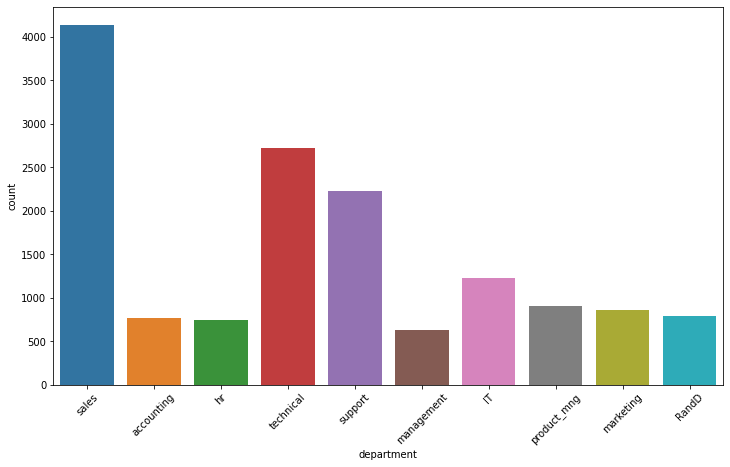

In [19]:
tmp = df.toPandas()

fig, ax =plt.subplots(1,1,figsize=(12,6))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s0 = sns.countplot(x="department", data=tmp)
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

plt.show()

Checking the types of salary and the number of employees fallinf into that group

In [20]:
df.groupby('salary').count().show()

+------+-----+
|salary|count|
+------+-----+
|   low| 7316|
|  high| 1237|
|medium| 6446|
+------+-----+



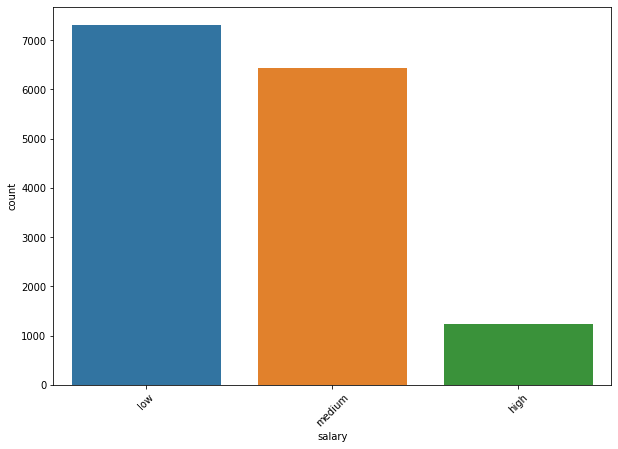

In [21]:
tmp = df.toPandas()

fig, ax =plt.subplots(1,1,figsize=(10,6))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s0 = sns.countplot(x="salary", data=tmp)
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

plt.show()

Checking the count of employees who left the organisation and employees who are still in the organisation.
"0" means didnot leave
"1" means left the organisation

In [22]:
df.groupby('left').count().show()

+----+-----+
|left|count|
+----+-----+
|   1| 3571|
|   0|11428|
+----+-----+



Changing the values values of left column from "0" to "no" and "1" to "yes"

In [23]:
y_udf = udf(lambda y: "no" if y == 0 else "yes", StringType())
df = df.withColumn("left",y_udf('left'))

In [24]:
df.groupby('left').count().show()

+----+-----+
|left|count|
+----+-----+
|  no|11428|
| yes| 3571|
+----+-----+



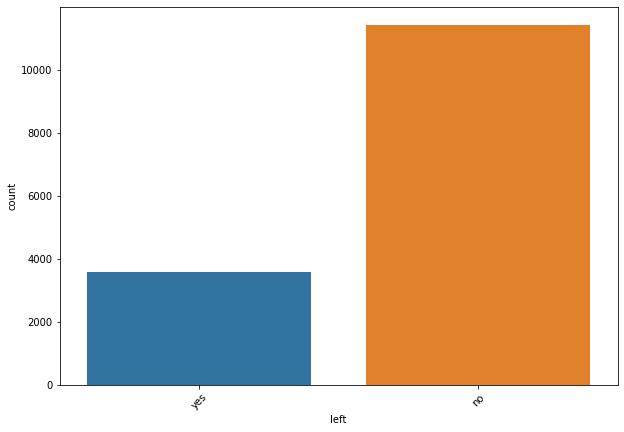

In [25]:
tmp = df.toPandas()

fig, ax =plt.subplots(1,1,figsize=(10,6))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s0 = sns.countplot(x="left", data=tmp)
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

plt.show()

trying to check division of salary for each department

In [26]:
df.groupby('department','salary').count().sort("department").show()

+-----------+------+-----+
| department|salary|count|
+-----------+------+-----+
|         IT|medium|  535|
|         IT|  high|   83|
|         IT|   low|  609|
|      RandD|medium|  372|
|      RandD|  high|   51|
|      RandD|   low|  364|
| accounting|  high|   74|
| accounting|medium|  335|
| accounting|   low|  358|
|         hr|  high|   45|
|         hr|   low|  335|
|         hr|medium|  359|
| management|medium|  225|
| management|   low|  180|
| management|  high|  225|
|  marketing|   low|  402|
|  marketing|medium|  376|
|  marketing|  high|   80|
|product_mng|medium|  383|
|product_mng|   low|  451|
+-----------+------+-----+
only showing top 20 rows



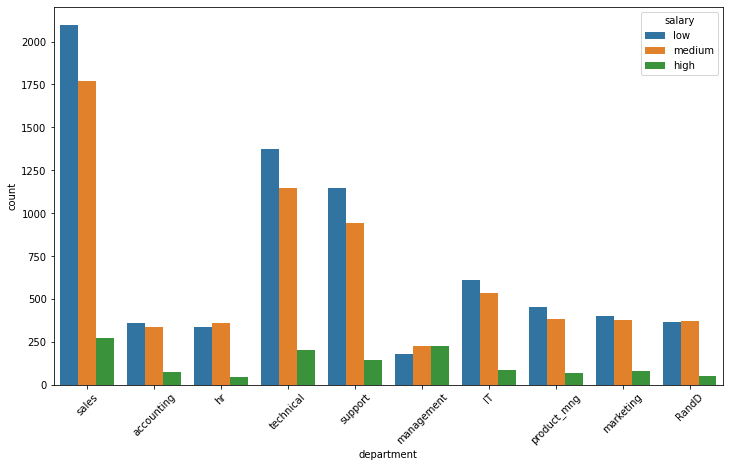

In [27]:
tmp = df.toPandas()

fig, ax =plt.subplots(1,1,figsize=(12,6))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s0 = sns.countplot(x="department", hue = "salary", data=tmp)
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

plt.show()

Checking the number of employees who left or still working in the organisation for each department

In [26]:
df.groupby('department','left').count().sort("department").show()

+-----------+----+-----+
| department|left|count|
+-----------+----+-----+
|         IT| yes|  273|
|         IT|  no|  954|
|      RandD| yes|  121|
|      RandD|  no|  666|
| accounting|  no|  563|
| accounting| yes|  204|
|         hr|  no|  524|
|         hr| yes|  215|
| management|  no|  539|
| management| yes|   91|
|  marketing|  no|  655|
|  marketing| yes|  203|
|product_mng|  no|  704|
|product_mng| yes|  198|
|      sales|  no| 3126|
|      sales| yes| 1014|
|    support| yes|  555|
|    support|  no| 1674|
|  technical| yes|  697|
|  technical|  no| 2023|
+-----------+----+-----+



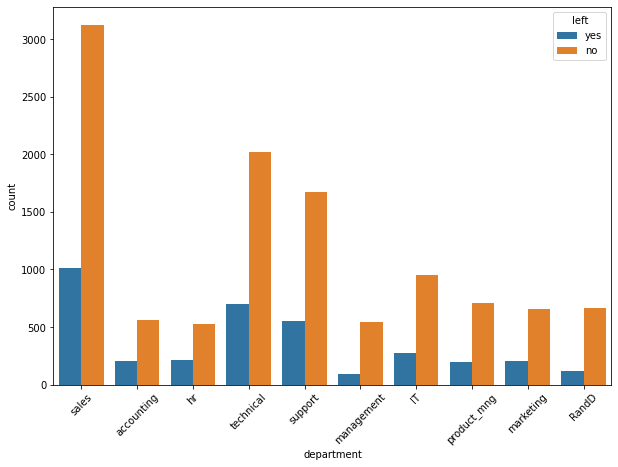

In [27]:
tmp = df.toPandas()

fig, ax =plt.subplots(1,1,figsize=(10,6))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s0 = sns.countplot(x="department", hue = "left", data=tmp)
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

plt.show()

Checking the number of employees who left or still working in the organisation for each salary group

In [28]:
df.groupby('salary','left').count().sort("salary").show()

+------+----+-----+
|salary|left|count|
+------+----+-----+
|  high|  no| 1155|
|  high| yes|   82|
|   low| yes| 2172|
|   low|  no| 5144|
|medium|  no| 5129|
|medium| yes| 1317|
+------+----+-----+



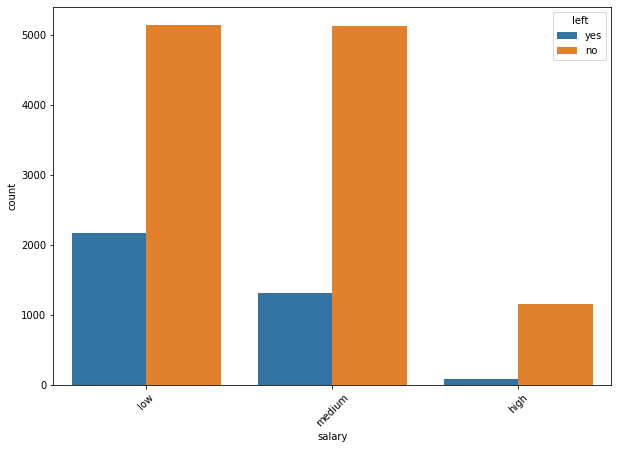

In [29]:
tmp = df.toPandas()

fig, ax =plt.subplots(1,1,figsize=(10,6))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s0 = sns.countplot(x="salary", hue = "left", data=tmp)
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

plt.show()

Checking the number of employees who got prmotion in the last 5 years.
* "0" means the employee did not get a promotion
* "1" means the employee got a promotion

In [30]:
df.groupby('promotion_last_5years').count().show()

+---------------------+-----+
|promotion_last_5years|count|
+---------------------+-----+
|                    1|  319|
|                    0|14680|
+---------------------+-----+



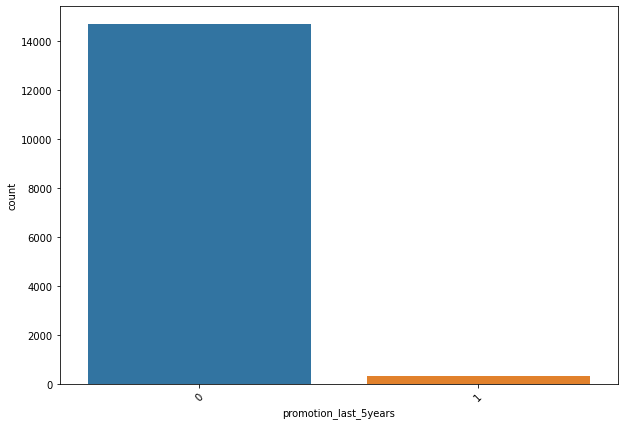

In [31]:
tmp = df.toPandas()

fig, ax =plt.subplots(1,1,figsize=(10,6))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s0 = sns.countplot(x="promotion_last_5years", data=tmp)
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

plt.show()

Cheking the number of employees who left or did not leave the organisation based on the promotion in last 5 years

In [32]:
df.groupby('promotion_last_5years','left').count().sort("promotion_last_5years").show()

+---------------------+----+-----+
|promotion_last_5years|left|count|
+---------------------+----+-----+
|                    0|  no|11128|
|                    0| yes| 3552|
|                    1| yes|   19|
|                    1|  no|  300|
+---------------------+----+-----+



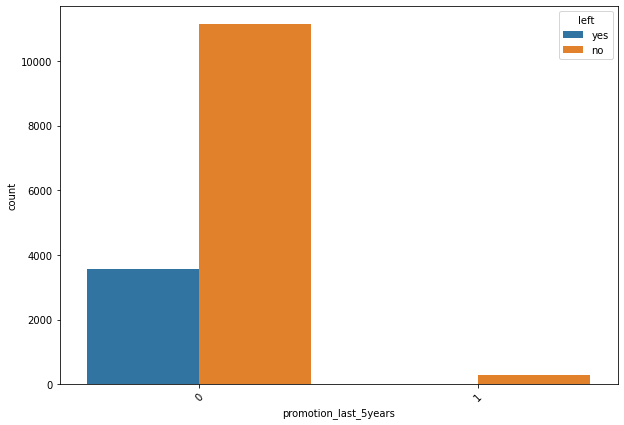

In [33]:
tmp = df.toPandas()

fig, ax =plt.subplots(1,1,figsize=(10,6))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s0 = sns.countplot(x="promotion_last_5years", hue = "left", data=tmp)
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

plt.show()

Checking how many employees suffered accident during work

* "0" means suffered from accident
* "1" means didnot suffer from accident

In [34]:
df.groupby('Work_accident').count().show()

+-------------+-----+
|Work_accident|count|
+-------------+-----+
|            1| 2169|
|            0|12830|
+-------------+-----+



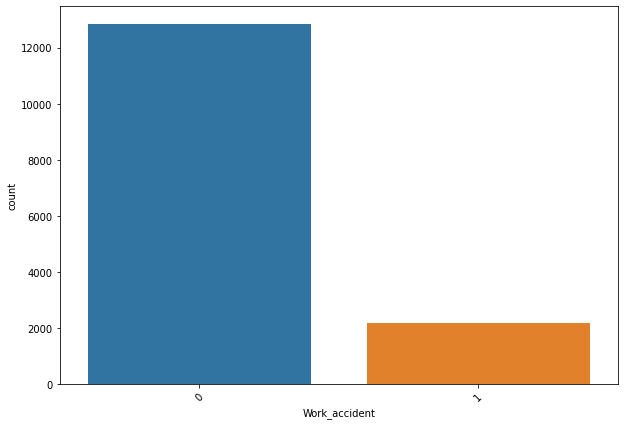

In [35]:
tmp = df.toPandas()

fig, ax =plt.subplots(1,1,figsize=(10,6))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s0 = sns.countplot(x="Work_accident", data=tmp)
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

plt.show()

Checking how many of the employees suffered accident during work left the organisation

In [36]:
df.groupby('Work_accident','left').count().sort("Work_accident").show()

+-------------+----+-----+
|Work_accident|left|count|
+-------------+----+-----+
|            0|  no| 9428|
|            0| yes| 3402|
|            1| yes|  169|
|            1|  no| 2000|
+-------------+----+-----+



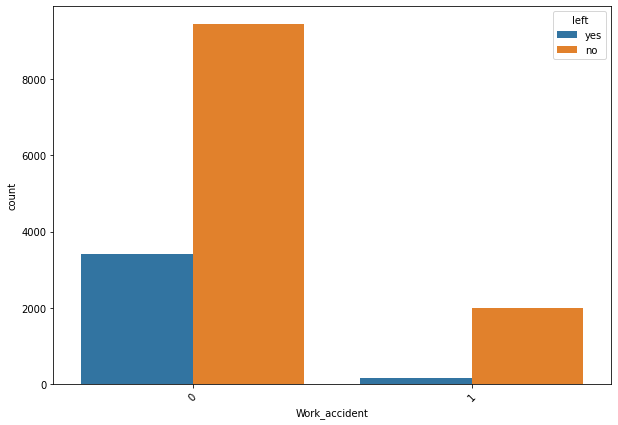

In [37]:
tmp = df.toPandas()

fig, ax =plt.subplots(1,1,figsize=(10,6))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s0 = sns.countplot(x="Work_accident", hue = "left", data=tmp)
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

plt.show()

Checking the number of projects employees used to get and also checking the count of the employees for the same

In [38]:
df.groupby('number_project').count().show()

+--------------+-----+
|number_project|count|
+--------------+-----+
|             6| 1174|
|             3| 4055|
|             5| 2761|
|             4| 4365|
|             7|  256|
|             2| 2388|
+--------------+-----+



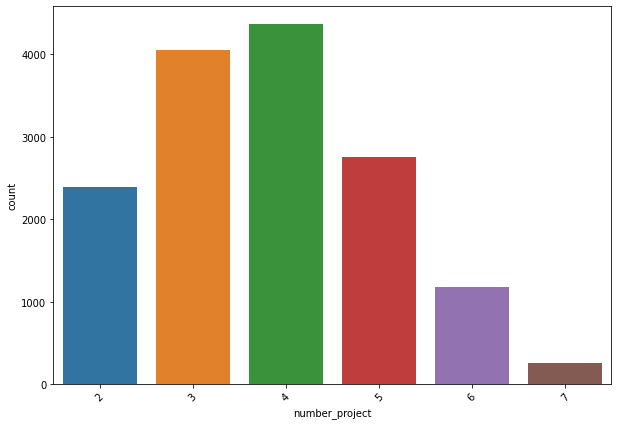

In [39]:
tmp = df.toPandas()

fig, ax =plt.subplots(1,1,figsize=(10,6))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s0 = sns.countplot(x="number_project", data=tmp)
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

plt.show()

Checking and trying to understand if the employees left the oranisation due to more number of projects on an individual

In [40]:
df.groupby('number_project','left').count().sort("number_project").show()

+--------------+----+-----+
|number_project|left|count|
+--------------+----+-----+
|             2|  no|  821|
|             2| yes| 1567|
|             3| yes|   72|
|             3|  no| 3983|
|             4|  no| 3956|
|             4| yes|  409|
|             5|  no| 2149|
|             5| yes|  612|
|             6| yes|  655|
|             6|  no|  519|
|             7| yes|  256|
+--------------+----+-----+



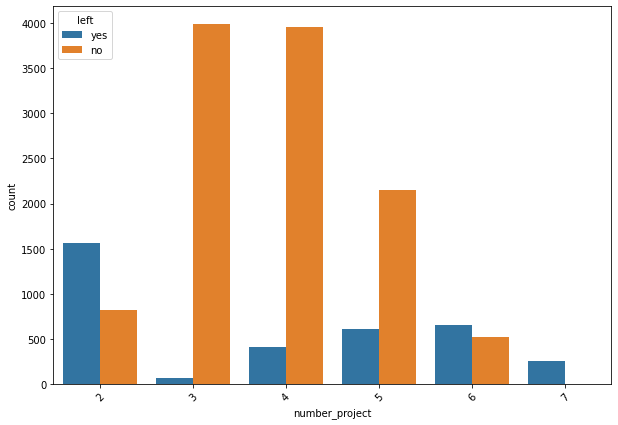

In [41]:
tmp = df.toPandas()

fig, ax =plt.subplots(1,1,figsize=(10,6))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s0 = sns.countplot(x="number_project", hue = "left", data=tmp)
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

plt.show()

Checking the mean satisfaction level of the employees who left the organisation and the ones who did not leave

  left  avg(satisfaction_level)
0   no                 0.666810
1  yes                 0.440098


[Text(0, 0, 'no'), Text(0, 0, 'yes')]

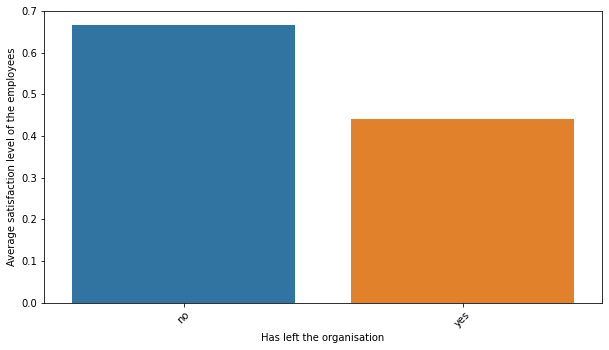

In [42]:
temp = df.groupby('left').agg({'satisfaction_level': 'mean'}).toPandas()
print(temp)
fig, ax = plt.subplots(1,1, figsize=(10,6))
plt.subplots_adjust(hspace = 0.4, top = 0.8)
s0 = sns.barplot(x="left", y="avg(satisfaction_level)", data=temp)
s0.set(xlabel='Has left the organisation',ylabel='Average satisfaction level of the employees')
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

Checking the average points secured in the last evaluation by the employees who left the organisation and the ones who did not

  left  avg(last_evaluation)
0   no              0.715473
1  yes              0.718113


[Text(0, 0, 'no'), Text(0, 0, 'yes')]

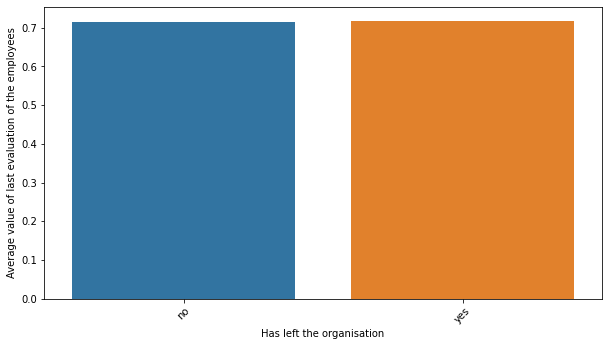

In [43]:
temp = df.groupby('left').agg({'last_evaluation': 'mean'}).toPandas()
print(temp)
fig, ax = plt.subplots(1,1, figsize=(10,6))
plt.subplots_adjust(hspace = 0.4, top = 0.8)
s0 = sns.barplot(x="left", y="avg(last_evaluation)", data=temp)
s0.set(xlabel='Has left the organisation',ylabel='Average value of last evaluation of the employees')
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

Checking the average monthly hours worked by the employees who left the organisation and the ones who did not

  left  avg(average_montly_hours)
0   no                 199.060203
1  yes                 207.419210


[Text(0, 0, 'no'), Text(0, 0, 'yes')]

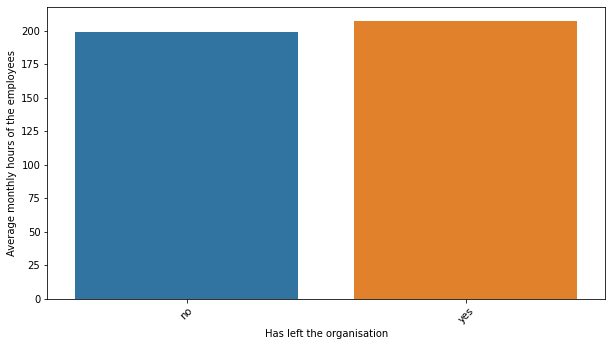

In [44]:
temp = df.groupby('left').agg({'average_montly_hours': 'mean'}).toPandas()
print(temp)
fig, ax = plt.subplots(1,1, figsize=(10,6))
plt.subplots_adjust(hspace = 0.4, top = 0.8)
s0 = sns.barplot(x="left", y="avg(average_montly_hours)", data=temp)
s0.set(xlabel='Has left the organisation',ylabel='Average monthly hours of the employees')
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

  left  avg(time_spend_company)
0   no                 3.380032
1  yes                 3.876505


[Text(0, 0, 'no'), Text(0, 0, 'yes')]

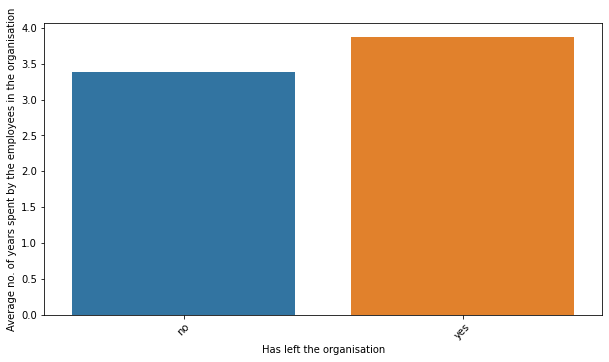

In [45]:
temp = df.groupby('left').agg({'time_spend_company': 'mean'}).toPandas()
print(temp)
fig, ax = plt.subplots(1,1, figsize=(10,6))
plt.subplots_adjust(hspace = 0.4, top = 0.8)
s0 = sns.barplot(x="left", y="avg(time_spend_company)", data=temp)
s0.set(xlabel='Has left the organisation',ylabel='Average no. of years spent by the employees in the organisation')
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

Taking out the numeric features from the data frame

In [46]:
numeric_features = [t[0] for t in df.dtypes if t[1] !='string']
numeric_features_df = df.select(numeric_features)
numeric_features_df.toPandas().head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
0,0.38,0.53,2,157,3,0,0
1,0.80,0.86,5,262,6,0,0
2,0.11,0.88,7,272,4,0,0
3,0.72,0.87,5,223,5,0,0
4,0.37,0.52,2,159,3,0,0


In [47]:
col_names = numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])

Checking the correlation among the numeric features

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
satisfaction_level,1.00,0.11,-0.14,-0.02,-0.10,0.06,0.03
last_evaluation,0.11,1.00,0.35,0.34,0.13,-0.01,-0.01
number_project,-0.14,0.35,1.00,0.42,0.20,-0.00,-0.01
average_montly_hours,-0.02,0.34,0.42,1.00,0.13,-0.01,-0.00
time_spend_company,-0.10,0.13,0.20,0.13,1.00,0.00,0.07
Work_accident,0.06,-0.01,-0.00,-0.01,0.00,1.00,0.04
promotion_last_5years,0.03,-0.01,-0.01,-0.00,0.07,0.04,1.00


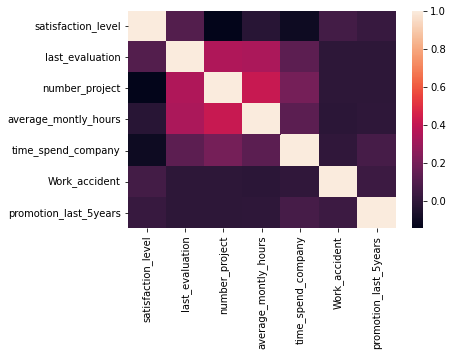

In [48]:
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index = col_names
corr_df.columns = col_names
sns.heatmap(corr_df)
round(corr_df, 2)

# Feature Engineering

Taking out the categorical features in "cat_feature" variable and the numeric features in "num_feature" variable from the train data

In [49]:
cat_feature = [x for (x, y) in df.dtypes if (y == 'string') & (x != 'left')]
num_feature = [x for (x,y) in df.dtypes if (y == 'double') or (y == 'int')]

In [50]:
cat_feature

['department', 'salary']

In [51]:
num_feature

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'promotion_last_5years']

## One-Hot Encoding

since the categorical featuresin the data set are string values, it becomes necessary to use StringIndexer first to convert the string values into label indices (numeric values).
Hence using StringIndexer

In [52]:
indexer = StringIndexer(inputCol="department", outputCol="department_Label")
temp_sdf = indexer.fit(df).transform(df)
df1 = temp_sdf.withColumn("department_Label", temp_sdf["department_Label"].cast("integer"))
df1.show(2)

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+----------------+
|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|department|salary|department_Label|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+----------------+
|              0.38|           0.53|             2|                 157|                 3|            0| yes|                    0|     sales|   low|               0|
|               0.8|           0.86|             5|                 262|                 6|            0| yes|                    0|     sales|medium|               0|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+----------

In [53]:
indexer = StringIndexer(inputCol="salary", outputCol="salary_label")
temp_sdf = indexer.fit(df1).transform(df1)
df1 = temp_sdf.withColumn("salary_label", temp_sdf["salary_label"].cast("integer"))
df1.show(2)

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+----------------+------------+
|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|department|salary|department_Label|salary_label|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+----------------+------------+
|              0.38|           0.53|             2|                 157|                 3|            0| yes|                    0|     sales|   low|               0|           0|
|               0.8|           0.86|             5|                 262|                 6|            0| yes|                    0|     sales|medium|               0|           1|
+------------------+---------------+--------------+--------------------+------------------+----

droping the "department" and "Salary" features

In [54]:
df1 = df1.drop('department','salary')

In [55]:
df1.show(2)

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------------+------------+
|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|department_Label|salary_label|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------------+------------+
|              0.38|           0.53|             2|                 157|                 3|            0| yes|                    0|               0|           0|
|               0.8|           0.86|             5|                 262|                 6|            0| yes|                    0|               0|           1|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------------+------------+
only showing top 2 row

Applying one-hot encoding 

In [56]:
encoder = OneHotEncoder(inputCols=["department_Label","salary_label"], outputCols=["department_OHE", "salary_OHE"])
df1 = encoder.fit(df1).transform(df1)

In [57]:
df1.show(5)

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------------+------------+--------------+-------------+
|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|department_Label|salary_label|department_OHE|   salary_OHE|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------------+------------+--------------+-------------+
|              0.38|           0.53|             2|                 157|                 3|            0| yes|                    0|               0|           0| (9,[0],[1.0])|(2,[0],[1.0])|
|               0.8|           0.86|             5|                 262|                 6|            0| yes|                    0|               0|           1| (9,[0],[1.0])|(2,[1],[1.0])|
|              0.11|           0.88|    

Defining the Target variable

In [58]:
stringIndexer = StringIndexer(inputCol='left', outputCol='label')

temp_sdf = stringIndexer.fit(df1).transform(df1)
df1 = temp_sdf.withColumn("label", temp_sdf["label"].cast("integer"))
df1.show(5)

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------------+------------+--------------+-------------+-----+
|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|department_Label|salary_label|department_OHE|   salary_OHE|label|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------------+------------+--------------+-------------+-----+
|              0.38|           0.53|             2|                 157|                 3|            0| yes|                    0|               0|           0| (9,[0],[1.0])|(2,[0],[1.0])|    1|
|               0.8|           0.86|             5|                 262|                 6|            0| yes|                    0|               0|           1| (9,[0],[1.0])|(2,[1],[1.0])|    1|
|         

Defining the features

In [59]:
cols = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years', 'department_Label', 'salary_label']
va = VectorAssembler(inputCols=cols, outputCol="FEATURES")
va_df = va.transform(df1)
va_df.show(5)

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------------+------------+--------------+-------------+-----+--------------------+
|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|department_Label|salary_label|department_OHE|   salary_OHE|label|            FEATURES|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------------+------------+--------------+-------------+-----+--------------------+
|              0.38|           0.53|             2|                 157|                 3|            0| yes|                    0|               0|           0| (9,[0],[1.0])|(2,[0],[1.0])|    1|[0.38,0.53,2.0,15...|
|               0.8|           0.86|             5|                 262|                 6|            0| yes|              

In [60]:
final_df = va_df.select("FEATURES", "label")
final_df.show(5)

+--------------------+-----+
|            FEATURES|label|
+--------------------+-----+
|[0.38,0.53,2.0,15...|    1|
|[0.8,0.86,5.0,262...|    1|
|[0.11,0.88,7.0,27...|    1|
|[0.72,0.87,5.0,22...|    1|
|[0.37,0.52,2.0,15...|    1|
+--------------------+-----+
only showing top 5 rows



Scaling the features using StandardScaler

In [61]:
scaler = StandardScaler(inputCol="FEATURES", outputCol="SCALED_FEATURES")
final_df = scaler.fit(final_df).transform(final_df)

In [62]:
final_df = final_df.drop('FEATURES')

### Split the dataset into test and train sets

In [63]:
train_df, test_df = final_df.randomSplit([0.7, 0.3], seed=17)
train_df.show(10)
test_df.show(10)


+-----+--------------------+
|label|     SCALED_FEATURES|
+-----+--------------------+
|    0|[0.48264363017128...|
|    0|[0.48264363017128...|
|    0|[0.48264363017128...|
|    0|[0.48264363017128...|
|    0|[0.48264363017128...|
|    0|[0.48264363017128...|
|    0|[0.48264363017128...|
|    0|[0.48264363017128...|
|    0|[0.48264363017128...|
|    0|[0.48264363017128...|
+-----+--------------------+
only showing top 10 rows

+-----+--------------------+
|label|     SCALED_FEATURES|
+-----+--------------------+
|    0|[0.48264363017128...|
|    0|[0.48264363017128...|
|    0|[0.48264363017128...|
|    0|[0.48264363017128...|
|    0|[0.48264363017128...|
|    0|[0.48264363017128...|
|    0|[0.48264363017128...|
|    0|[0.48264363017128...|
|    0|[0.48264363017128...|
|    0|[0.52286393268555...|
+-----+--------------------+
only showing top 10 rows



In [64]:
train_df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 2529|
|    0| 7963|
+-----+-----+



In [65]:
test_df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 1042|
|    0| 3465|
+-----+-----+



# Model building

## Logistic Regression

fitting the model

In [66]:
log_model = LogisticRegression(featuresCol='SCALED_FEATURES', labelCol='label').fit(train_df)


predicting using the test_df

In [67]:
y_pred = log_model.transform(test_df)
y_pred.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|     SCALED_FEATURES|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.48264363017128...|[-0.4866837077832...|[0.38067511193412...|       1.0|
|    0|[0.48264363017128...|[-0.2410646323506...|[0.44002400552878...|       1.0|
|    0|[0.48264363017128...|[-1.1231833403843...|[0.24542128412853...|       1.0|
|    0|[0.48264363017128...|[0.56035206884842...|[0.63653399830551...|       0.0|
|    0|[0.48264363017128...|[0.12467625061085...|[0.53112875055255...|       0.0|
|    0|[0.48264363017128...|[0.12467625061085...|[0.53112875055255...|       0.0|
|    0|[0.48264363017128...|[1.32380300335571...|[0.78981373133998...|       0.0|
|    0|[0.48264363017128...|[-1.2495033405432...|[0.22278612479530...|       1.0|
|    0|[0.48264363017128...|[-0.4945848094845...|[0.37881410002364...|       1.0|
|    0|[0.522863

In [68]:
y_pred.select("label", "prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
+-----+----------+
only showing top 20 rows



Checking the accuracy

In [69]:
# accuracy
y_pred.filter(y_pred.label == y_pred.prediction).count() / y_pred.count()

0.8069669403150654

Checking the accuracy, precision, recall, F1 score and ROC AUC

In [70]:
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName='areaUnderROC')
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

acc = evaluatorMulti.evaluate(y_pred, {evaluatorMulti.metricName: "accuracy"})
precision = evaluatorMulti.evaluate(y_pred, {evaluatorMulti.metricName: "precisionByLabel"})
recall = evaluatorMulti.evaluate(y_pred, {evaluatorMulti.metricName: "recallByLabel"})
f1 = evaluatorMulti.evaluate(y_pred, {evaluatorMulti.metricName: "f1"})
roc_auc = evaluator.evaluate(y_pred)

In [71]:
print("accuracy: %f, precision: %f, recall: %f, f1: %f, roc_auc: %f" % (acc, precision, recall, f1, roc_auc))

accuracy: 0.806967, precision: 0.839927, recall: 0.925253, f1: 0.792017, roc_auc: 0.669440
